In [0]:
########### Instalar Cartopy
!pip install cartopy
!pip install --no-binary shapely shapely --force
# get package then extract
!wget https://anaconda.org/conda-forge/cartopy/0.16.0/download/linux-64/cartopy-0.16.0-py36h81b52dc_2.tar.bz2
!tar xvjf cartopy-0.16.0-py36h81b52dc_2.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
# install dependencies
!pip install shapely pyshp
!apt install libproj-dev libgeos-dev

     |████████████████████████████████| 8.9MB 4.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 /usr/local/lib/python3.6/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmpcgfs57ea Check the logs for full command output.
     |████████████████████████████████| 358kB 4.7MB/s 
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.0
    Uninstalling Shapely-1.7.0:
      Successfully uninstalled Shapely-1.7.0
    Running setup.py install for shapely ... done
--2020-04-22 18:21:23--  https://anaconda.org/conda-forge/cartopy/0.16.0/download/linux-64/cartopy-0.16.0-py36h81b52dc_2.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:

In [0]:
## Dowload direto do google drive
!pip install googledrivedownloader

In [0]:
import h5py #### Bibliote para abrir aquivos 
from tqdm.notebook import trange #### Mostra a barra de load do carregamento 
import matplotlib.pyplot as plt #### Para plotagem
import numpy as np #Biblioteca com pacote matematica
import random ## Biblioteca Aleatoria
from sklearn.preprocessing import MinMaxScaler ## Biblioteca para normalizar 
from tensorflow.keras.layers import Dense,Dropout,Conv3D,Input,Flatten,GaussianNoise ### Camdas que ultilizaremos
from tensorflow.keras.models import Sequential ### Modelo Sequencial
from tensorflow.keras.optimizers import Adam ### Otimizardor
from tensorflow.keras.callbacks import ReduceLROnPlateau ### Reduzir LR automatica
from sklearn.model_selection import train_test_split ### Dividir o test e train
import cartopy.crs as ccrs ###### Plotar dados em mapa
from google_drive_downloader import GoogleDriveDownloader as gdd

In [31]:
gdd.download_file_from_google_drive(file_id='1sYI2jwQ86e6h4BjSta1NJfeKNzYQCMbT',
                                    dest_path='./PARES_RADAR_PUVIO.tar.xz',showsize=True,overwrite=True ,
                                    unzip=False)

35.1 MiB Done.


In [32]:
!tar -xvf PARES_RADAR_PUVIO.tar.xz

PARES_RADAR_PUVIO.hdf5


In [0]:
######## Função de normalização Tanh, e desnormalização, para mais informação entre em :
## https://alfurka.github.io/2018-11-10-preprocessing-for-nn/ 
def tanh_norm(x,mean,std):
    return 0.5*np.tanh(0.01*((x-mean)/std))
def unorm_tanh(x,mean,std):
    return ((np.arctanh(x/0.5)/0.01)*std)+mean

In [0]:
f = h5py.File('PARES_RADAR_PUVIO.hdf5', 'r') ### Abrir arquivo hdf5 

In [35]:
#Nesta parte iremos dividir o arquivos de entrada e saida
X=[]
Y=[]
for i in trange(int(len(list(f.keys()))/2)):
    X.append(f['exp_%s'%i][:])
    Y.append(float(f['target_%s'%i][:][0]))
X=np.array(X)
Y=np.array(Y)
f.close()

In [0]:
### Calular a media e desvio padão, e normalizar com tanh
mean=np.mean(Y)
std=np.std(Y)
Y_norm=[]
for i in range(len(Y)):
    Y_norm.append(tanh_norm(Y[i],mean,std))
Y_norm=np.array(Y_norm)

In [0]:
#tranforma o dado em 2D e normalizar entre 0,1 os dados de entrada
sh=X.shape
X=np.reshape(X,(sh[0]*sh[1]*sh[2]*sh[3],sh[4]))
scaler=MinMaxScaler((0,1))
X=scaler.fit_transform(X)
X=np.reshape(X,sh)

In [0]:
### Dividir a parte de test e treinament
X_train, X_test, y_train, y_test = train_test_split(
    X, Y_norm, test_size=0.1, random_state=2442)

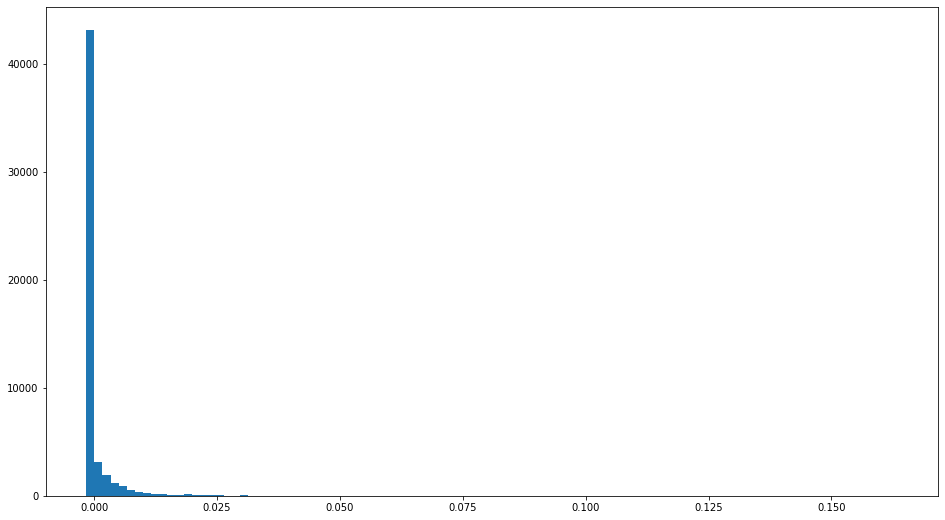

In [39]:
## Histograma da precipitação
fig=plt.figure(figsize=(16,9))
plt.hist(y_train,bins=100)
plt.show()

In [40]:
# Aqui iremos equilibrar os arquivos os exemplos diminuindo as amostras sem chuva e aumentado os exemplos de chuva
bx=[]
by=[]
arr=np.array(np.where(y_train<=0.)[0][:],dtype=int)
np.random.shuffle(arr)
##################
for i in trange(80000):
    idx=random.choice(arr)
    bx.append(X_train[idx])
    by.append(y_train[idx])
###################
arr=np.array(np.where(y_train>0.0)[0][:],dtype=int)
np.random.shuffle(arr)
for i in trange(150000):
    idx=random.choice(arr)
    bx.append(X_train[idx])
    by.append(y_train[idx])
bx=np.array(bx,dtype=float)
by=np.array(by,dtype=float)

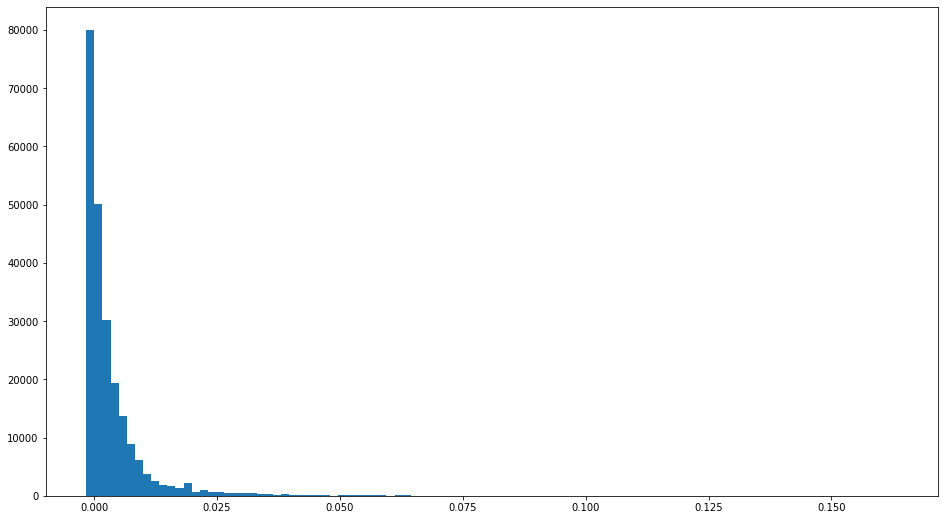

In [41]:
### Disbruição de frequencia nova dos dados atualizados
fig=plt.figure(figsize=(16,9))
plt.hist(by,bins=100)
plt.show()

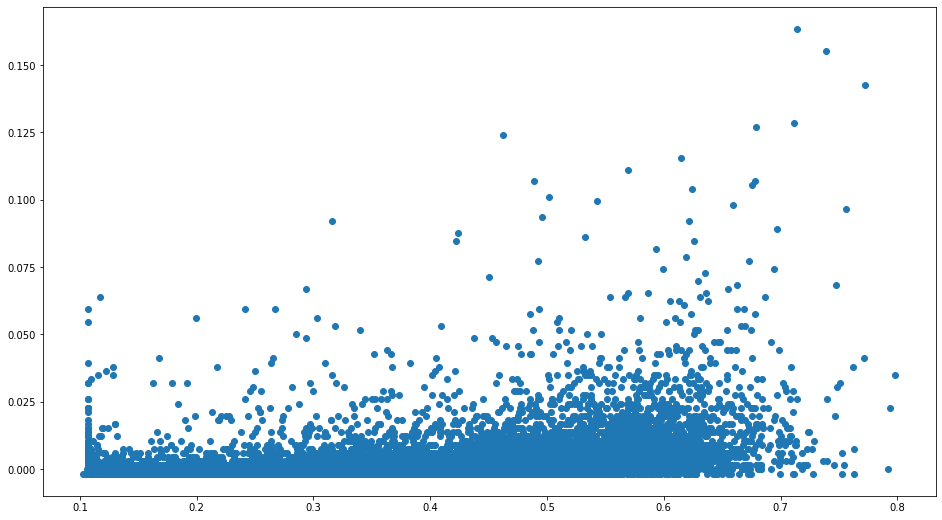

In [42]:
# Aqui iremos plotar a relação entre a media da refletividade nos pixeis
# e a chuva observadada nos pluviometros
dbz_mean=[]
for i in range(len(X_train)):
    dbz_mean.append(X_train[i,0,:,:,0].mean())
fig=plt.figure(figsize=(16,9))
plt.plot(dbz_mean,y_train,'o')

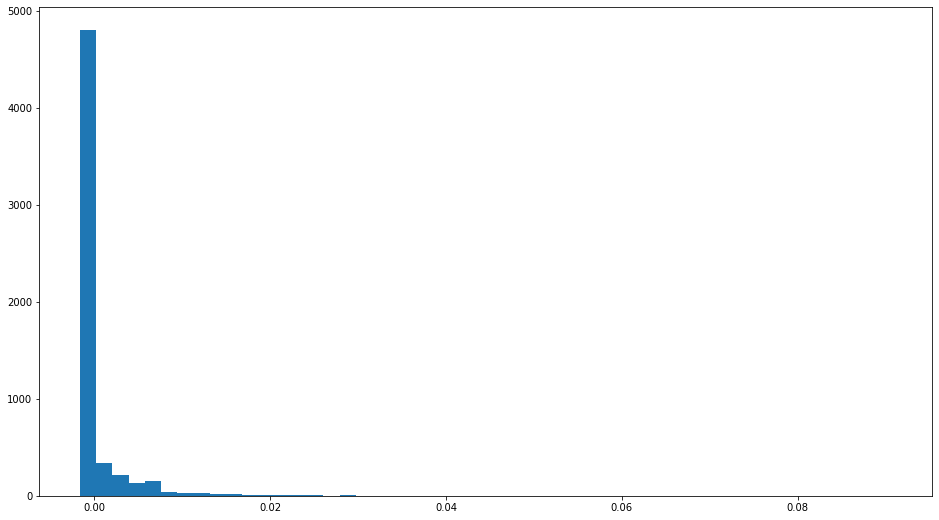

In [43]:
#Distribuição de frequencia dos dados de test 
fig=plt.figure(figsize=(16,9))
plt.hist(y_test,bins=50)
plt.show()

In [0]:
#### Nesta parte do codigo definiremos nossa rede neural
model=Sequential()
model.add(Input((6,7,7,2)))
model.add(GaussianNoise(stddev=0.3))
model.add(Conv3D(16,(6,7,2),activation='tanh'))
model.add(Flatten())
model.add(Dense(32,activation='tanh'))
model.add(Dense(1,activation='tanh'))

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 6, 7, 7, 2)        0         
_________________________________________________________________
conv3d (Conv3D)              (None, 1, 1, 6, 16)       2704      
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                3104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,841
Trainable params: 5,841
Non-trainable params: 0
_________________________________________________________________


In [0]:
########## Compilaremos o modelo
model.compile(loss='logcosh',optimizer='Adam') ## o optimizer= Adam

In [0]:
#### A função abaixo reduz a taxa de aprendizendo mais informaçoes :
### http://deeplearningbook.com.br/a-taxa-de-aprendizado-de-uma-rede-neural/
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=10, min_lr=0.00001,verbose=1)

In [50]:
### Aqui iremos treinar a rere com os dados ja processados 
history=model.fit(bx,by,verbose=1,epochs=50,batch_size=32,
                  validation_data=(X_test,y_test),callbacks=[reduce_lr])

Epoch 1/50
7188/7188 [==============================] - 15s 2ms/step - loss: 1.7758e-04 - val_loss: 7.6178e-06 - lr: 0.0010
Epoch 2/50
7188/7188 [==============================] - 16s 2ms/step - loss: 3.5612e-05 - val_loss: 1.0002e-05 - lr: 0.0010
Epoch 3/50
7188/7188 [==============================] - 15s 2ms/step - loss: 3.4362e-05 - val_loss: 1.0500e-05 - lr: 0.0010
Epoch 4/50
7188/7188 [==============================] - 15s 2ms/step - loss: 3.4575e-05 - val_loss: 2.5179e-05 - lr: 0.0010
Epoch 5/50
7188/7188 [==============================] - 15s 2ms/step - loss: 3.4203e-05 - val_loss: 7.7705e-06 - lr: 0.0010
Epoch 6/50
7188/7188 [==============================] - 15s 2ms/step - loss: 3.4374e-05 - val_loss: 9.6930e-06 - lr: 0.0010
Epoch 7/50
7188/7188 [==============================] - 15s 2ms/step - loss: 3.3365e-05 - val_loss: 6.9122e-06 - lr: 0.0010
Epoch 8/50
7188/7188 [==============================] - 15s 2ms/step - loss: 3.3534e-05 - val_loss: 8.1451e-06 - lr: 0.0010
Epoch 9/

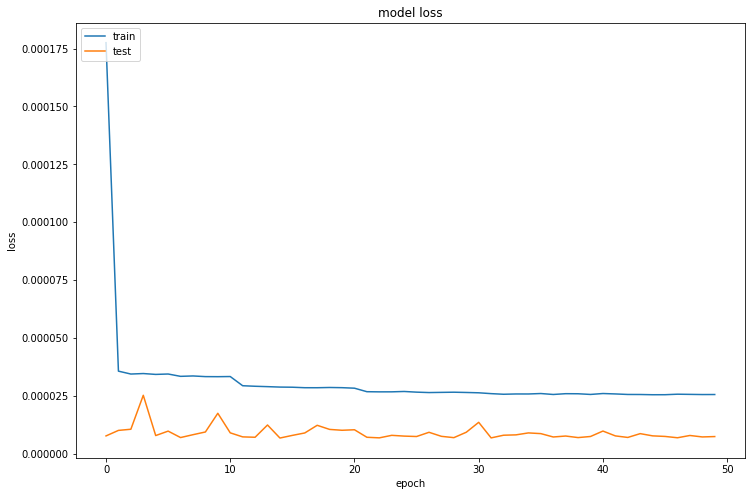

In [51]:
#### Plot do erro variando ao longo do treinamento 
fig=plt.figure(figsize=(12,8))
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
pre=model.predict(X_train) ####### Faços as previsoess
pre_unorm=[] ## Desnormalização
for i in range(len(pre)):
    pre_unorm.append(unorm_tanh(pre[i,0],mean,std))
pre_unorm=np.array(pre_unorm)

array([[1.        , 0.63243628],
       [0.63243628, 1.        ]])

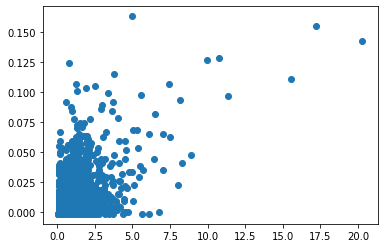

In [53]:
plt.plot(pre_unorm,y_train,'o')
np.corrcoef(pre_unorm,y_train)

In [64]:
! git clone https://github.com/otaviomf123/Cusor-ML-para-Meteorologia-2020-04-20.git

Cloning into 'Cusor-ML-para-Meteorologia-2020-04-20'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [66]:
!ls Cusor-ML-para-Meteorologia-2020-04-20

'Curso de ML aplicado a meteorologia_Aula01.pdf'  'RPEL_2019-11-27 02:50:00.h5'
 curso_ML.ipynb					  'RPEL_2019-12-15 09:00:00.h5'
 INMET_A801.csv					  'RPEL_2019-12-15 12:00:00.h5'
'RPEL_2019-11-22 13:10:00.h5'


In [0]:
ler_radar=h5py.File('./Cusor-ML-para-Meteorologia-2020-04-20/RPEL_2019-12-15 09:00:00.h5','r')
lat=ler_radar['lat'][:]
lon=ler_radar['lon'][:]
dbz=ler_radar['dbz'][:]
vel=ler_radar['vel'][:]

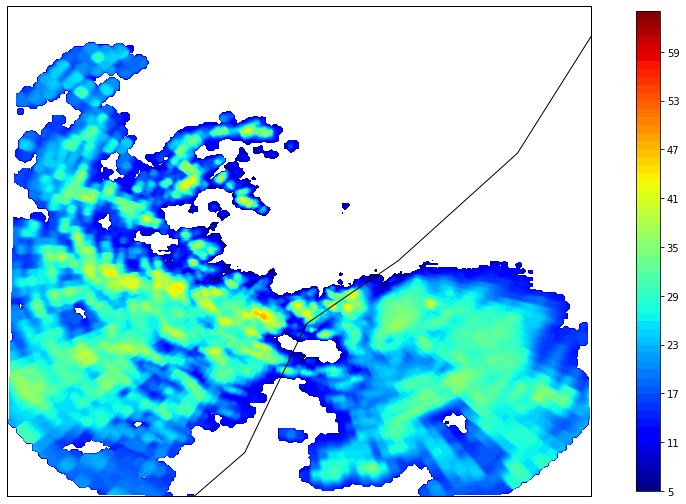

In [71]:
fig = plt.figure(figsize=(16, 9))
fig.clf()
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_extent([np.min(lon), np.max(lon), np.min(lat), np.max(lat)])
clev=np.arange(5,65,1)
mapable=ax.contourf(lon,lat,dbz[1][:],clev,
                transform=ccrs.PlateCarree(),
                cmap='jet')

fig.colorbar(mapable,ax=ax, shrink=.98)
ax.coastlines()
plt.show()

In [0]:
### Iremos preparar os dados para serem extrapolados para todo o radar
dbz=np.array(dbz)
vel=np.array(vel)
lat_red=[]
lon_red=[]
xi=[]
for i in range(3,len(lat)-3):
    for j in range(3,len(lon)-3):
        xii=[]
        xii.append(dbz[:,i-3:i+4,j-3:j+4])
        xii.append(vel[:,i-3:i+4,j-3:j+4])
        xi.append(xii)
        lat_red.append(lat[i,j])
        lon_red.append(lon[i,j])
rede_input=np.array(xi)
lat_red=np.array(lat_red)
lon_red=np.array(lon_red)

In [0]:
dbz=np.array(dbz)
vel=np.array(vel)
lat_red=[]
lon_red=[]
xi=[]
for i in range(3,len(lat)-3):
    for j in range(3,len(lon)-3):
        xii=[]
        xii.append(dbz[:,i-3:i+4,j-3:j+4])
        xii.append(vel[:,i-3:i+4,j-3:j+4])
        xi.append(xii)
        lat_red.append(lat[i,j])
        lon_red.append(lon[i,j])
rede_input=np.array(xi)
lat_red=np.array(lat_red)

In [0]:
rede_input=np.moveaxis(rede_input,1,-1)
#tranforma o dado em 2D e normalizar entre 0,1 os dados de entrada
sh=rede_input.shape
rede_input=np.reshape(rede_input,(sh[0]*sh[1]*sh[2]*sh[3],sh[4]))
rede_input=scaler.transform(rede_input)
rede_input=np.reshape(rede_input,sh)

In [0]:
######## Prever para todo o radar
pred_test=model.predict(rede_input)[:,0]
pre_unorm_test=[]
for i in range(len(pred_test)):
    pre_unorm_test.append(unorm_tanh(pred_test[i],mean,std))
pre_unorm_test=np.array(pre_unorm_test)

In [0]:
lat_red=np.reshape(lat_red,(250,250))
pre_unorm_test=np.reshape(pre_unorm_test,(250,250))
lon_red=np.reshape(lon_red,(250,250))

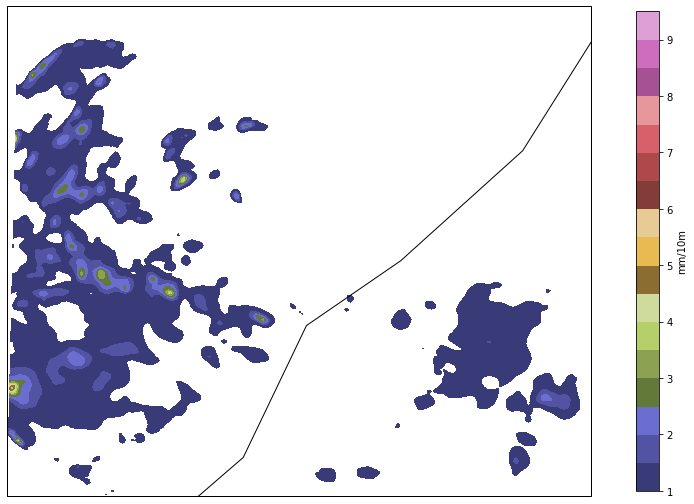

In [79]:
### plotar o resultado final
fig = plt.figure(figsize=(16, 9))
fig.clf()
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_extent([np.min(lon_red), np.max(lon_red), np.min(lat_red), np.max(lat_red)])
clev=np.arange(1,10,0.5)
mapable=ax.contourf(lon_red,lat_red,pre_unorm_test,clev,
                transform=ccrs.PlateCarree(),
                cmap='tab20b')

fig.colorbar(mapable,ax=ax, shrink=.98,label='mm/10m')
ax.coastlines()
plt.show()